<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:2%; font-size:50px">Bees, Wasps or Other Insects</h1>
<hr>
<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Imports</h1>


In [1]:
import os
import PIL
import cv2
import math
import random
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, \
classification_report, log_loss ,precision_recall_curve, balanced_accuracy_score

<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Constants and Global Variables</h1>


In [2]:
DATASET_PATH = '../Datasets/On Door/'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
SAMPLE_RATE = 22050

In [3]:
models = {
    'buzzingDetection':layers.SimpleRNN, 
    'insectDetection': None, 
    'beeOrNot': None, 
    'waspOrNot': None, 
    'decisionMaking': None
    }
datasets = ['BuzzOrNot', 'BeeOrNot', 'WaspOrNot']

<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Evaluation</h1>


In [4]:
def evaluateModel(yTrue, yPred, yProb=None):
    accuracy = accuracy_score(yTrue, yPred)
    print(f"Accuracy: {accuracy:.4f}")
    
    balancedAcc = balanced_accuracy_score(yTrue, yPred)
    print(f"Balanced Accuracy: {balancedAcc:.4f}")
    
    precision = precision_score(yTrue, yPred)
    print(f"Precision: {precision:.4f}")
    
    recall = recall_score(yTrue, yPred)
    print(f"Recall: {recall:.4f}")
    
    f1 = f1_score(yTrue, yPred)
    print(f"F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(yTrue, yPred)
    print(f"Confusion Matrix:\n{cm}")
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if yProb is not None:
        rocAuc = roc_auc_score(yTrue, yProb)
        print(f"ROC AUC Score: {rocAuc:.4f}")
        
        fpr, tpr, _ = roc_curve(yTrue, yProb)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {rocAuc:.4f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
        
        precisionCurve, recallCurve, _ = precision_recall_curve(yTrue, yProb)
        plt.figure(figsize=(6, 4))
        plt.plot(recallCurve, precisionCurve, label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend(loc="lower left")
        plt.show()

    if yProb is not None:
        logloss = log_loss(yTrue, yProb)
        print(f"Log Loss: {logloss:.4f}")

<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:1%">Buzz Detection (Sound Classification)</h1>


---


<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Audio Segmentation</h2>


In [5]:
def loadAudio(sub='/train'):
    print(f"\nLoading audio data from {DATASET_PATH + datasets[0] + sub}...")
    PATH = DATASET_PATH + datasets[0] + sub
    segments = []
    targets = []
    
    for filename in os.listdir(PATH):
        if filename.endswith('.wav'):
            audio = os.path.join(PATH, filename)
            label = filename.split('.')[0].split('_')[0]
            try:
                audio, sampleRate = librosa.load(audio)
                segments.append(audio)
                targets.append('Buzzing' if filename.startswith( 'Bee') else 'No Buzzing')
            except:
                os.remove(audio)
  
    return segments, np.array(targets)       

<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Audio Pre-Proccessing</h2>


In [6]:
def extractMFCC(segments, n_mfcc=12):
    print(f"\nPadded MFCC extraction for {len(segments)} segments...")
    mfccs = []
    mfccs = [librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE, n_mfcc=n_mfcc) for segment in segments]
    return mfccs, max([mfcc.shape[1] for mfcc in mfccs])


In [7]:
def pad(mfccs, maxLength):
    features = [
        np.pad(mfcc, ((0, 0), (0, maxLength - mfcc.shape[1])), mode='constant') 
        for mfcc in mfccs
    ]
    return np.array(features)

<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Audio PipeLine</h2>


In [8]:
def audioPipeline():
    xTrain, yTrain = loadAudio('/train/')
    xTest, yTest = loadAudio('/test/')
    xTrain, maxTrainLength = extractMFCC(xTrain)
    xTest, maxTestLength = extractMFCC(xTest)
    xTrain = pad(xTrain, max(maxTrainLength, maxTestLength))
    xTest = pad(xTest, max(maxTrainLength, maxTestLength))
    yTrain = np.array([1 if label == 'Buzzing' else 0 for label in yTrain])
    yTest = np.array([1 if label == 'Buzzing' else 0 for label in yTest])
    xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)
    return xTrain, yTrain, xVal, yVal, xTest, yTest

<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:1%">Bee Detection (Image Classification)</h1>
<hr>
<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Loading Images</h2>


In [9]:
def loadImages(index, sub, positive):
    print(f"\nLoading image data from {DATASET_PATH + datasets[index] + sub}...")
    PATH = DATASET_PATH + datasets[index] + sub
    subDirs = [d for d in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, d))]
    targets = []
    images = []
    
    for target in subDirs:
        targetPath = os.path.join(PATH, target)   
        
        for filename in os.listdir(targetPath):
            if filename.endswith(('.jpg', '.png')): 
                image = os.path.join(targetPath, filename)
                img = cv2.imread(image)
                img = cv2.resize(img, IMAGE_SIZE) 
                targets.append(target)
                images.append(img)
    targets = np.array([1 if target == positive else 0 for target in targets])            
    return np.array(images), np.array(targets)

In [10]:
def extractImages(index, positive):
    xTrain, yTrain = loadImages(index, '/train/', positive)
    xTest, yTest = loadImages(index, '/test/', positive)
    xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)
    
    return xTrain, yTrain, xVal, yVal, xTest, yTest

<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Model Building</h1>


In [11]:
def buildForBuzz(shape, modelType):  
        print(f"\nBuilding {modelType.__name__} with input shape {shape}...")
        model = Sequential()
        model.add(layers.Input(shape=shape))
        
        model.add(modelType(128, return_sequences=True))
        model.add(modelType(64))
        #model.add(layers.Dense(64, activation='tanh'))

        
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        return model

In [12]:
def buildForInsects():
    model = Sequential()
    resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),pooling='avg')
    
    for layer in resnet.layers:
        layer.trainable=False
        
    model.add(resnet)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
def train(model, xTrain, yTrain, xVal, yVal):
    print(f"\nTraining {model.layers[0].__class__.__name__} model...")
    model.fit(xTrain, yTrain, validation_data=(xVal, yVal), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True)
    predictions = model.predict(xVal)
    predictions = np.array([1 if pred > 0.5 else 0 for pred in predictions])
    evaluateModel(yVal, predictions)
    return model

In [14]:
def test(model, xTest, yTest):
    predictions = model.predict(xTest)
    predictions = np.array([1 if pred > 0.5 else 0 for pred in predictions])
    evaluateModel(yTest, predictions)

<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:2%">Main</h1>



Loading audio data from ../Datasets/On Door/BuzzOrNot/train/...

Loading audio data from ../Datasets/On Door/BuzzOrNot/test/...

Padded MFCC extraction for 1984 segments...

Padded MFCC extraction for 853 segments...

Building LSTM with input shape (12, 432)...

Training LSTM model...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7863 - loss: 0.4535 - val_accuracy: 0.9471 - val_loss: 0.1595
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9594 - loss: 0.1301 - val_accuracy: 0.9622 - val_loss: 0.1234
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9813 - loss: 0.0762 - val_accuracy: 0.9496 - val_loss: 0.1298
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9910 - loss: 0.0420 - val_accuracy: 0.9647 - val_loss: 0.1044
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9985 - loss: 0.0103 - val_accuracy: 0.9622 - val_loss: 0.0965
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9987 - loss: 

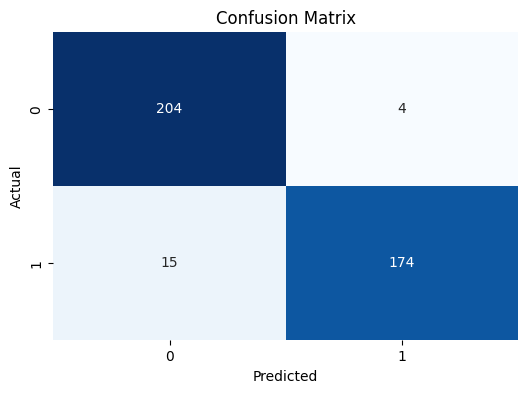

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.9484
Balanced Accuracy: 0.9484
Precision: 0.9775
Recall: 0.9178
F1 Score: 0.9467
Confusion Matrix:
[[418   9]
 [ 35 391]]


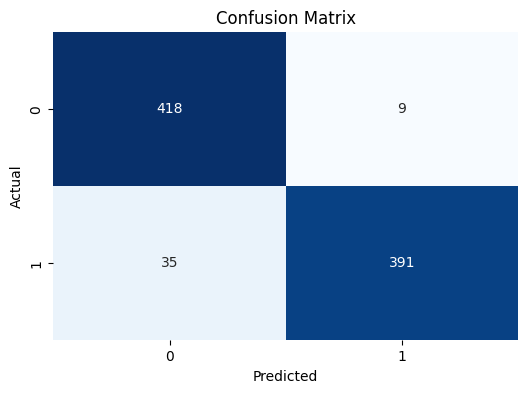


Building GRU with input shape (12, 432)...

Training GRU model...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7636 - loss: 0.4403 - val_accuracy: 0.9244 - val_loss: 0.2030
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9544 - loss: 0.1393 - val_accuracy: 0.9345 - val_loss: 0.1782
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9876 - loss: 0.0597 - val_accuracy: 0.9345 - val_loss: 0.1758
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9883 - loss: 0.0416 - val_accuracy: 0.9194 - val_loss: 0.2253
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9846 - loss: 0.0541 - val_accuracy: 0.9093 - val_loss: 0.2835
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9709 - loss: 0.0806 - val_accuracy: 0.9395 - val_loss: 0.1801
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9897 - loss: 0.0309 - val_accuracy: 0.9395 - val_loss: 0.2345
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11m

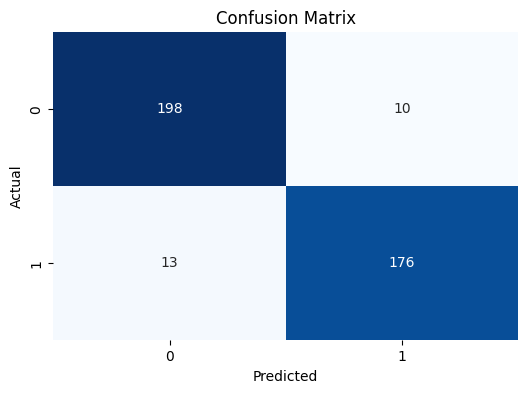

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9039
Balanced Accuracy: 0.9039
Precision: 0.8945
Recall: 0.9155
F1 Score: 0.9049
Confusion Matrix:
[[381  46]
 [ 36 390]]


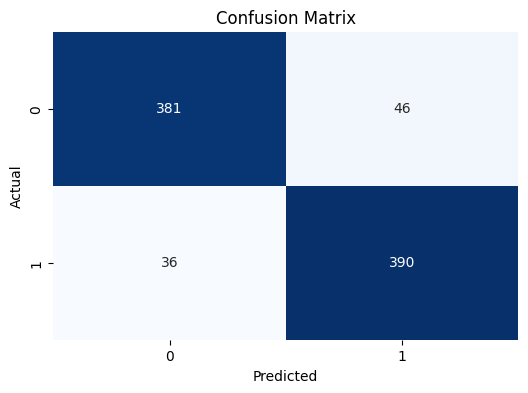


Building SimpleRNN with input shape (12, 432)...

Training SimpleRNN model...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7485 - loss: 0.5053 - val_accuracy: 0.9521 - val_loss: 0.2354
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9587 - loss: 0.1680 - val_accuracy: 0.9572 - val_loss: 0.1414
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9873 - loss: 0.0666 - val_accuracy: 0.9547 - val_loss: 0.1508
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9939 - loss: 0.0385 - val_accuracy: 0.9622 - val_loss: 0.1299
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9945 - loss: 0.0231 - val_accuracy: 0.9673 - val_loss: 0.1304
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9946 - loss: 0.0272 - val_accuracy: 0.9421 - val_loss: 0.1551
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0187 - val_accuracy: 0.9572 - val_loss: 0.1283
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 

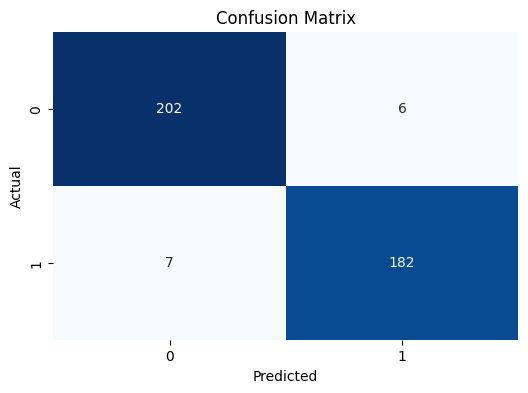

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9719
Balanced Accuracy: 0.9719
Precision: 0.9741
Recall: 0.9695
F1 Score: 0.9718
Confusion Matrix:
[[416  11]
 [ 13 413]]


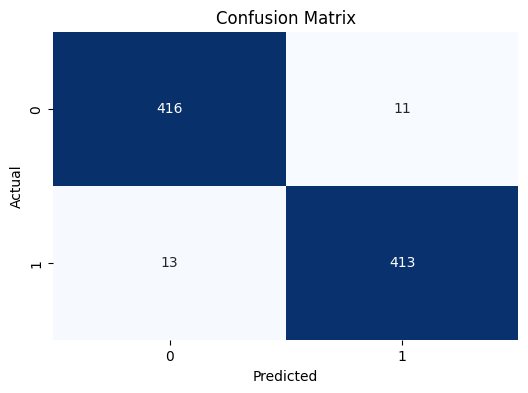

In [20]:
def compareAudioModels(): 
    xTrain, yTrain, xVal, yVal, xTest, yTest = audioPipeline()
    models = [layers.LSTM, layers.GRU, layers.SimpleRNN]
    for model in models:
        model = buildForBuzz(xTrain.shape[1:], model)
        model = train(model, xTrain, yTrain, xVal, yVal)
        test(model, xTest, yTest)
        
compareAudioModels()

In [16]:
def classifyInsects(index=1, positive="Bee"):
    xTrain, yTrain, xVal, yVal, xTest, yTest = extractImages(index, positive)
    model = buildForInsects();
    model = train(model, xTrain, yTrain, xVal, yVal)
    test(model, xTest, yTest)
    return model, xTest, yTest

In [17]:
def show(model, image, label, positive, negative):
    reshapedImg = np.expand_dims(image, axis=0)
    prediction = model.predict(reshapedImg)
    print(prediction)
    print('Predicted:', positive if prediction[0][0] > 0.5 else negative)
    print('True label:', positive if label == 1 else negative)
    cv2.imshow('Test Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def demo(beeModel, waspModel, image, label):
    show(beeModel, image, label, "Bee", "Not Bee") 
    reshapedImg = np.expand_dims(image, axis=0)
    prediction = beeModel.predict(reshapedImg)
    
    if prediction[0][0] <= 0.5: 
        show(waspModel, image, label, "Wasp", "Other Insects")


Loading image data from ../Datasets/On Door/BeeOrNot/train/...

Loading image data from ../Datasets/On Door/BeeOrNot/test/...

Training Functional model...
Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.8015 - loss: 0.4800 - val_accuracy: 0.8673 - val_loss: 0.2806
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8820 - loss: 0.2665 - val_accuracy: 0.8911 - val_loss: 0.2612
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8861 - loss: 0.2486 - val_accuracy: 0.8782 - val_loss: 0.2758
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.8956 - loss: 0.2329 - val_accuracy: 0.8906 - val_loss: 0.2572
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.9188 - loss: 0.1946 - val_accuracy: 0.8797 - val_loss: 0.2920
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.9086 - loss: 0.2062 - val_accuracy: 0.8782 - val_loss: 0.2848
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.92

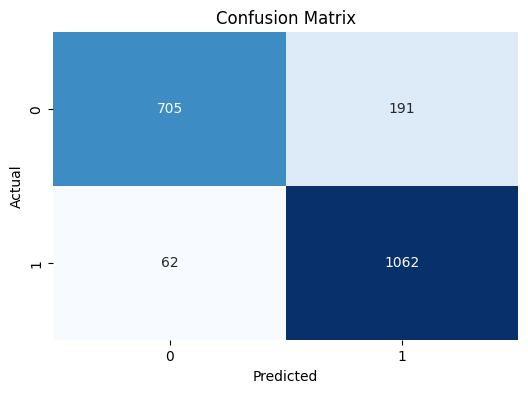

66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step
Accuracy: 0.8859
Balanced Accuracy: 0.8852
Precision: 0.8443
Recall: 0.9494
F1 Score: 0.8938
Confusion Matrix:
[[ 857  187]
 [  54 1014]]


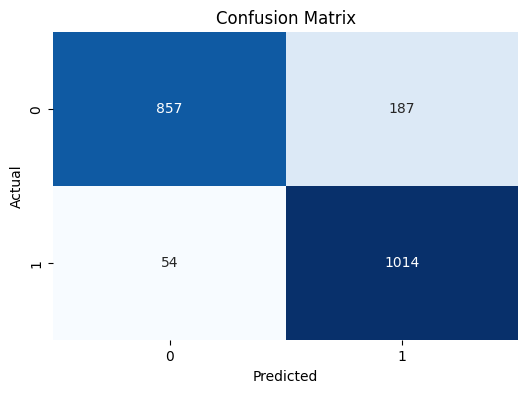


Loading image data from ../Datasets/On Door/WaspOrNot/train/...

Loading image data from ../Datasets/On Door/WaspOrNot/test/...

Training Functional model...
Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - accuracy: 0.7903 - loss: 0.4678 - val_accuracy: 0.8118 - val_loss: 0.3782
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 540s 1s/step - accuracy: 0.8528 - loss: 0.3080 - val_accuracy: 0.8424 - val_loss: 0.3152
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - accuracy: 0.8674 - loss: 0.2721 - val_accuracy: 0.8520 - val_loss: 0.3118
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - accuracy: 0.8777 - loss: 0.2517 - val_accuracy: 0.8419 - val_loss: 0.3380
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 541s 1s/step - accuracy: 0.8878 - loss: 0.2303 - val_accuracy: 0.8500 - val_loss: 0.3203
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - accuracy: 0.8894 - loss: 0.2214 - val_accuracy: 0.8453 - val_loss: 0.3367
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 540s 1s/step - accuracy: 0.

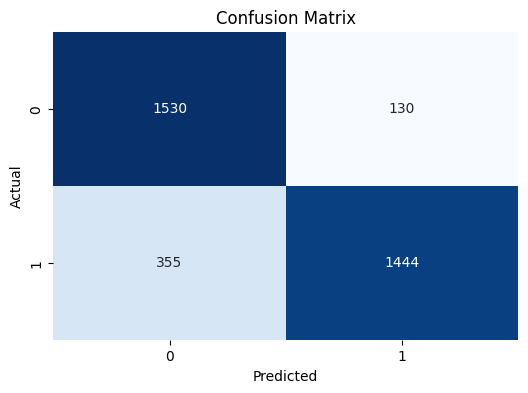

261/261 ━━━━━━━━━━━━━━━━━━━━ 260s 998ms/step
Accuracy: 0.9242
Balanced Accuracy: 0.9173
Precision: 0.9678
Recall: 0.9308
F1 Score: 0.9489
Confusion Matrix:
[[1831  195]
 [ 436 5862]]


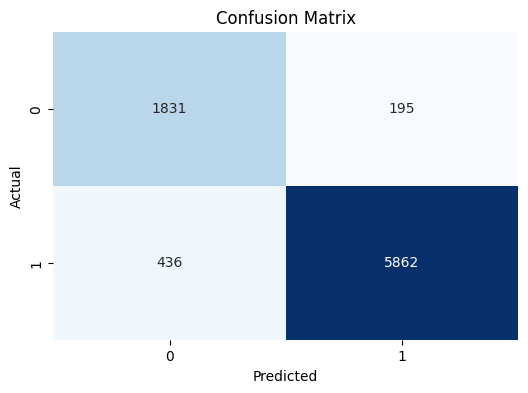

In [18]:
numSamples = 10
tester = []

beeOrNot, images, labels = classifyInsects(1, "Bee")
sample = random.sample(range(len(images)), numSamples)
for index in sample:
    tester.append((images[index], labels[index]))

waspOrNot, images, labels = classifyInsects(2, "Wasp")
sample = random.sample(range(len(images)), numSamples)
for index in sample:
    tester.append((images[index], labels[index]))


In [19]:
for image, label in tester:
    demo(beeOrNot, waspOrNot, image, label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
[[   0.035286]]
Predicted: Not Bee
True label: Not Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[[    0.38953]]
Predicted: Other Insects
True label: Other Insects
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
[[          1]]
Predicted: Bee
True label: Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[[    0.71226]]
Predicted: Bee
True label: Not Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[    0.80791]]
Predicted: Bee
True label: Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[[    0.23981]]
Predicted: Not Bee
True label: Not Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[[    0.12853]]
Predicted: Other Insects
True label: Other Insects
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[   0.061455]]
Predicted: Not Bee
True label: Not Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━